# StressGait Analysis - Saliva & Self-Reports

## Setup and Helper Functions

In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
from biopsykit.stats import StatsPipeline
from fau_colors import cmaps, register_fausans_font

from IPython.display import Markdown

from stressgait_analysis.dataset import StressGaitDataset

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
#register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait_palette = {
    "OMC": omc_color,
    "Control": controls_color
}
stressgait = [controls_color, omc_color]


In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
base_path

PosixPath('/home/rzlin/ys64ofuj/Data/StressGait/Data')

In [4]:
export_path = Path("../../exports")
plot_path = export_path.joinpath("plots")
bp.utils.file_handling.mkdirs([export_path, plot_path])

export_path

PosixPath('../../exports')

In [5]:
dataset = StressGaitDataset(base_path, coarse_condition=True)
dataset

,participant,condition
0,VP_01,OMC
1,VP_02,Control
2,VP_05,Control
3,VP_06,OMC
4,VP_07,Control
5,VP_08,Control
6,VP_11,Control
7,VP_12,Control
8,VP_13,OMC
9,VP_15,Control


In [6]:
order = ["Control", "OMC"]
hue_order = ["Control", "OMC"]

In [7]:
cortisol_samples = dataset.cortisol#.unstack().head()
cortisol_samples

cortisol
subject condition sample          
VP_01   OMC       S0           NaN
                  S1       1.86590
                  S2       4.40660
                  S3       4.78145
                  S4       2.47520
...                            ...
VP_47   OMC       S1       1.66690
                  S2       1.65975
                  S3       1.83425
                  S4       4.00655
                  S5       3.03780

[240 rows x 1 columns]

## Compute S0S1 Increase

The S0-S1 increase is computed as absolute increase (in nmol/l) and as increase relative to S0 (in percent).

In [8]:
s0s1_inc = dataset.cortisol.reindex(["S0", "S1"], level="sample").unstack().diff(axis=1).dropna(axis=1, how="all")
s0s1_inc_percent = (s0s1_inc / dataset.cortisol.xs("S0", level="sample").values) * 100

s0s1_inc.columns = pd.MultiIndex.from_tuples([("cortisol", "inc_S0S1")], names=[None, "saliva_feature"])
s0s1_inc_percent.columns = pd.MultiIndex.from_tuples([("cortisol", "inc_S0S1_percent")], names=[None, "saliva_feature"])

s0s1_inc.head()

,,cortisol
,saliva_feature,inc_S0S1
subject,condition,
VP_01,OMC,NaN
VP_02,Control,2.22980
VP_05,Control,0.15460
VP_06,OMC,8.07005
VP_07,Control,-0.28390


In [9]:
cortisol_features = dataset.cortisol_features.unstack().join(s0s1_inc).join(s0s1_inc_percent)
cortisol_features = cortisol_features.stack(future_stack=True)
cortisol_features.unstack().head()

cortisol                                                \
saliva_feature         auc_g      auc_i   max_inc max_inc_percent inc_S0S1   
subject condition                                                            
VP_01   OMC              NaN        NaN       NaN             NaN      NaN   
VP_02   Control    249.15050   64.93960   2.22980       70.206703  2.22980   
VP_05   Control     95.31840   16.52540   1.63200      120.132499  0.15460   
VP_06   OMC        453.54585  322.61375  10.72155      474.940752  8.07005   
VP_07   Control    190.79770  -56.50560  -0.28390       -6.658302 -0.28390   

                                    
saliva_feature    inc_S0S1_percent  
subject condition                   
VP_01   OMC                    NaN  
VP_02   Control          70.206703  
VP_05   Control          11.380199  
VP_06   OMC             357.485216  
VP_07   Control          -6.658302

In [10]:
cortisol_normalized = (dataset.cortisol.unstack() - dataset.cortisol.unstack()[[("cortisol", "S0")]].values).stack(
    future_stack=True
)
cortisol_normalized.unstack().head()

cortisol                                              
sample                  S0       S1       S2        S3       S4       S5
subject condition                                                       
VP_01   OMC            NaN      NaN      NaN       NaN      NaN      NaN
VP_02   Control        0.0  2.22980  2.11815   1.70670  0.56330  0.19610
VP_05   Control        0.0  0.15460  0.10655   1.63200  0.22375 -0.03810
VP_06   OMC            0.0  8.07005  7.48295  10.72155  5.94725  4.19355
VP_07   Control        0.0 -0.28390 -1.00475  -1.80540 -2.20870 -2.58710

## Results

### Cortisol Trajectories

#### Statistics

In [11]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "mixed_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "cortisol",
        "subject": "subject",
        "within": "sample",
        "between": "condition",
        "parametric": False,
        "multicomp": {"method": "bonf", "levels": True},
    },
)

pipeline.apply(dataset.cortisol)

pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,subject,within,between,parametric,multicomp
parameter,cortisol,subject,sample,condition,False,"{'method': 'bonf', 'levels': True}"


,prep,test,posthoc
parameter,normality,mixed_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
sample condition                          
S0     OMC        0.975541  0.8791    True
       Control    0.846637  0.0047   False
S1     OMC        0.954897  0.4475    True
       Control    0.817003  0.0016   False
S2     OMC        0.916727  0.0857    True
       Control    0.839680  0.0036   False
S3     OMC        0.792565  0.0007   False
       Control    0.776501  0.0004   False
S4     OMC        0.892028  0.0293   False
       Control    0.708973  0.0001   False
S5     OMC        0.917968  0.0906    True
       Control    0.897299  0.0367   False

<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,condition,148.911586,1,37,148.911586,10.582689,0.0024,NaN,0.222406,NaN,NaN,NaN,NaN
1,sample,29.192903,5,185,5.838581,6.051779,0.0000,0.002159,0.140570,0.465846,False,0.024968,2.052502e-21
2,Interaction,5.066590,5,185,1.013318,1.050320,0.3896,NaN,0.027603,NaN,NaN,NaN,NaN


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

,Contrast,sample,A,B,Paired,Parametric,U-val,W-val,alternative,p-unc,hedges,p-corr
0,sample,-,S0,S1,True,False,NaN,228.0,two-sided,0.0230,-0.281811,0.5066
1,sample,-,S0,S2,True,False,NaN,272.0,two-sided,0.1015,-0.238232,1.0000
2,sample,-,S0,S3,True,False,NaN,334.0,two-sided,0.4429,-0.204909,1.0000
3,sample,-,S0,S4,True,False,NaN,388.0,two-sided,0.9835,0.016666,1.0000
4,sample,-,S0,S5,True,False,NaN,301.0,two-sided,0.2195,0.262669,1.0000
5,sample,-,S1,S2,True,False,NaN,263.0,two-sided,0.0774,0.045053,1.0000
6,sample,-,S1,S3,True,False,NaN,273.0,two-sided,0.1045,0.071091,1.0000
7,sample,-,S1,S4,True,False,NaN,181.0,two-sided,0.0029,0.307173,0.0637
8,sample,-,S1,S5,True,False,NaN,126.0,two-sided,0.0001,0.547030,0.0025
9,sample,-,S2,S3,True,False,NaN,296.0,two-sided,0.1942,0.027156,1.0000


#### Absolute

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


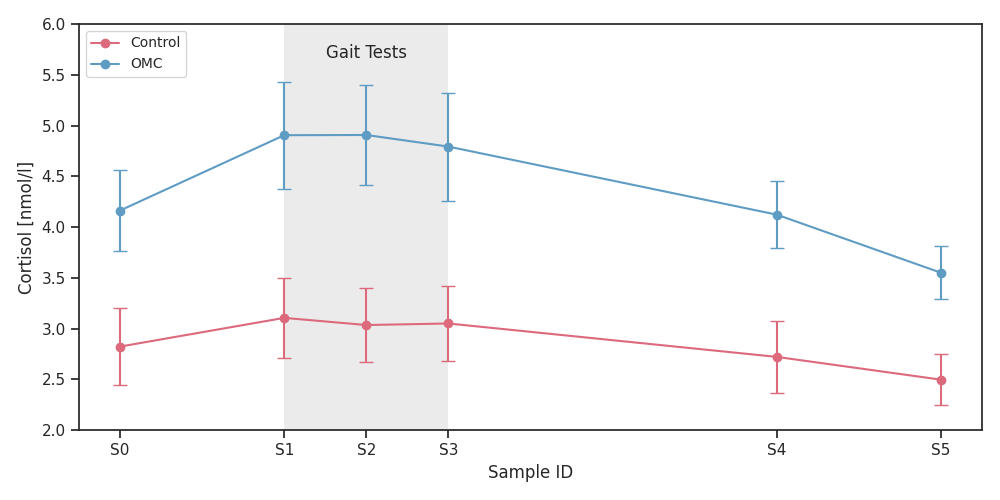

In [12]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=dataset.cortisol,
    saliva_type="cortisol",
    sample_times=[0, 1, 1.5, 2, 4, 5],
    test_times=[1, 2],
    test_title="Gait Tests",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)
ax.set_ylim([2, 6])
ax.set_xticklabels([f"S{i}" for i in range(0, 6)])
ax.set_xlabel("Sample ID")

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_cortisol_response_absolute_sample_ids.pdf"), transparent=True)

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


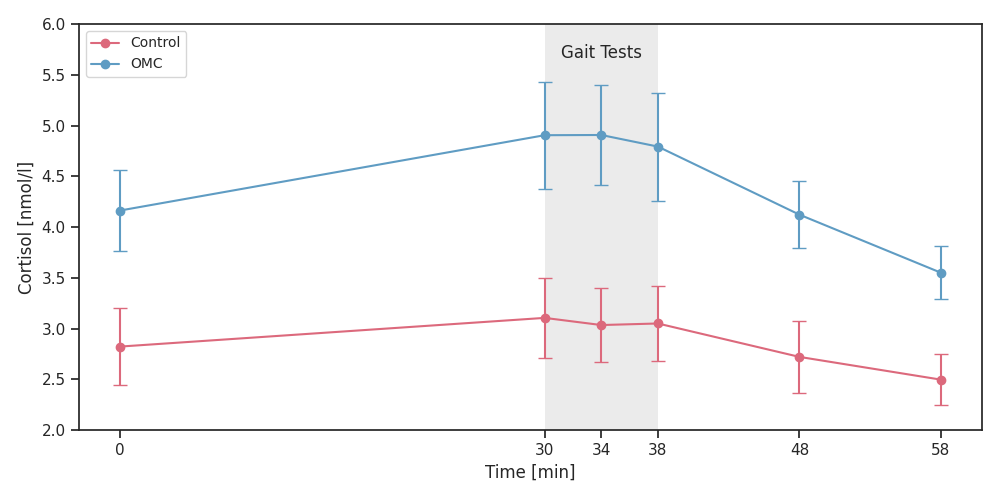

In [13]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=dataset.cortisol,
    saliva_type="cortisol",
    sample_times=dataset.sample_times,
    test_times=[30, 38],
    test_title="Gait Tests",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)
ax.set_ylim([2, 6])

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_cortisol_response_absolute_times.pdf"), transparent=True)

#### Increase to S0

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


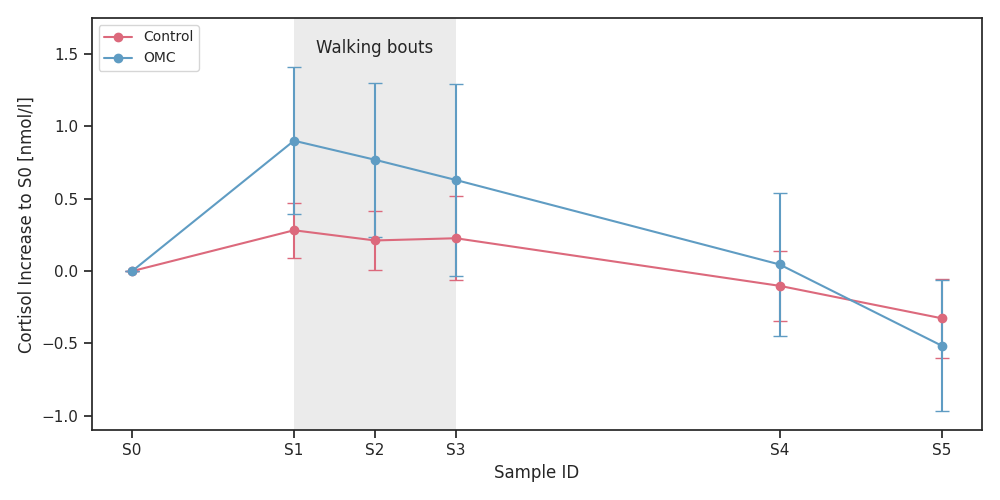

In [14]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=cortisol_normalized,
    saliva_type="cortisol",
    sample_times=[0, 1, 1.5, 2, 4, 5],
    test_times=[1, 2],
    test_title="Walking bouts",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)
ax.set_ylim([-1.1, 1.75])
ax.set_xticklabels([f"S{i}" for i in range(0, 6)])
ax.set_xlabel("Sample ID")
ax.set_ylabel("Cortisol Increase to S0 [nmol/l]")

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_cortisol_response_normalized_sample_ids.pdf"), transparent=True)

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


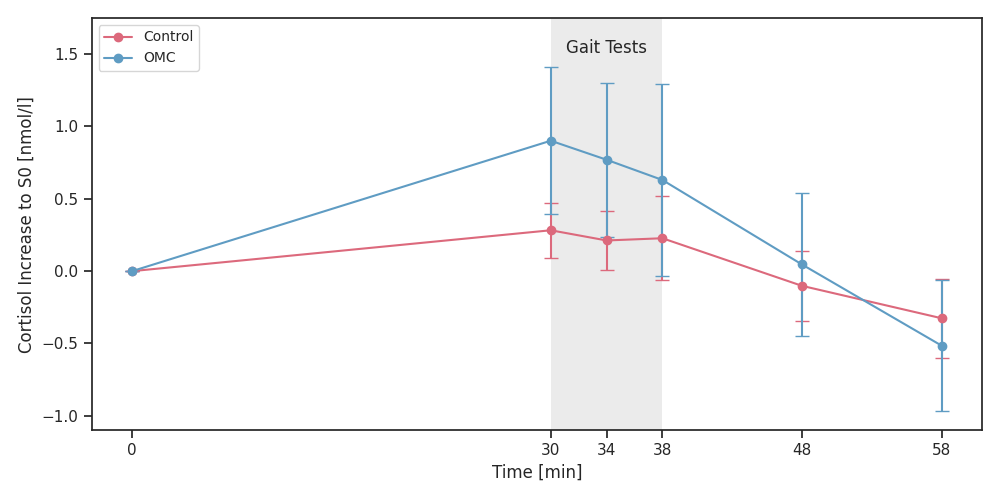

In [15]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=cortisol_normalized,
    saliva_type="cortisol",
    sample_times=dataset.sample_times,
    test_times=[30, 38],
    test_title="Gait Tests",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)

ax.set_ylim([-1.1, 1.75])
ax.set_ylabel("Cortisol Increase to S0 [nmol/l]")

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_cortisol_response_normalized_times.pdf"), transparent=True)

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


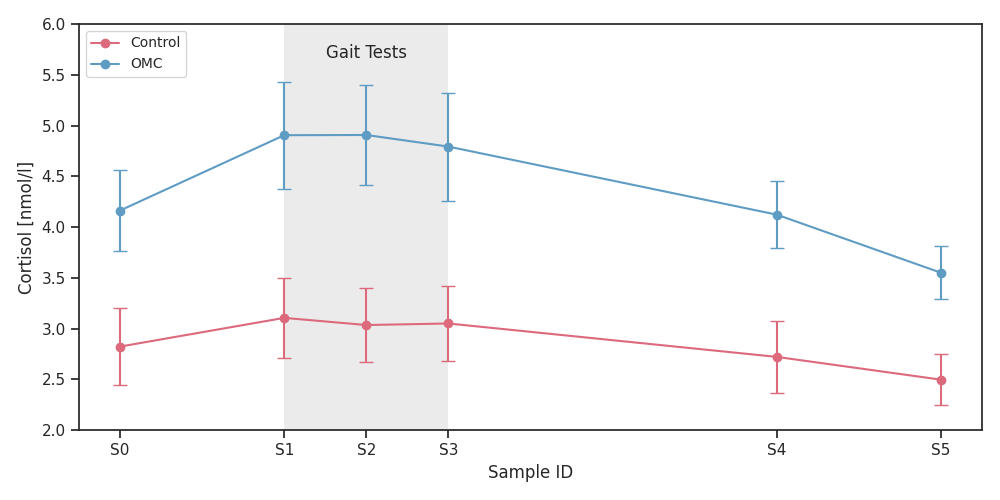

In [16]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=dataset.cortisol,
    saliva_type="cortisol",
    sample_times=[0, 1, 1.5, 2, 4, 5],
    test_times=[1, 2],
    test_title="Gait Tests",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)
ax.set_ylim([2, 6])
ax.set_xticklabels([f"S{i}" for i in range(0, 6)])
ax.set_xlabel("Sample ID")

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_cortisol_response_absolute_sample_ids.pdf"), transparent=True)

#### Boxplot of Individual Cortisol Samples

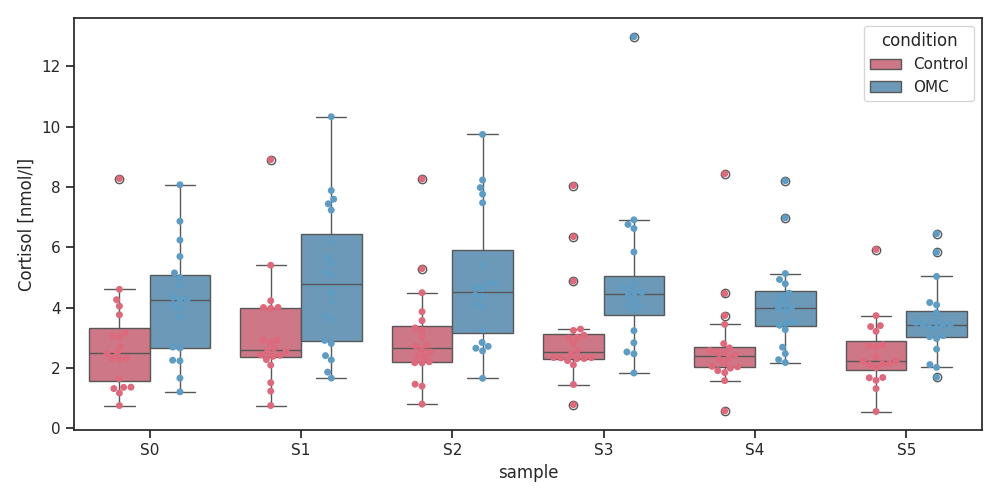

In [20]:
fig, ax = plt.subplots()

sns.boxplot(data=dataset.cortisol.reset_index(), x="sample", y="cortisol", hue="condition", hue_order=hue_order, ax=ax, palette=stressgait
                )
sns.swarmplot(
    data=dataset.cortisol.reset_index(),
    x="sample",
    y="cortisol",
    hue="condition",
    hue_order=hue_order,
    ax=ax,
    palette=stressgait,
    dodge=True,
    legend=False,

)

ax.set_ylabel("Cortisol [nmol/l]")

fig.tight_layout()
fig.savefig(plot_path.joinpath("img_boxplot_cortisol_samples.pdf"), transparent=True)


#### Individual Cortisol Trajectories

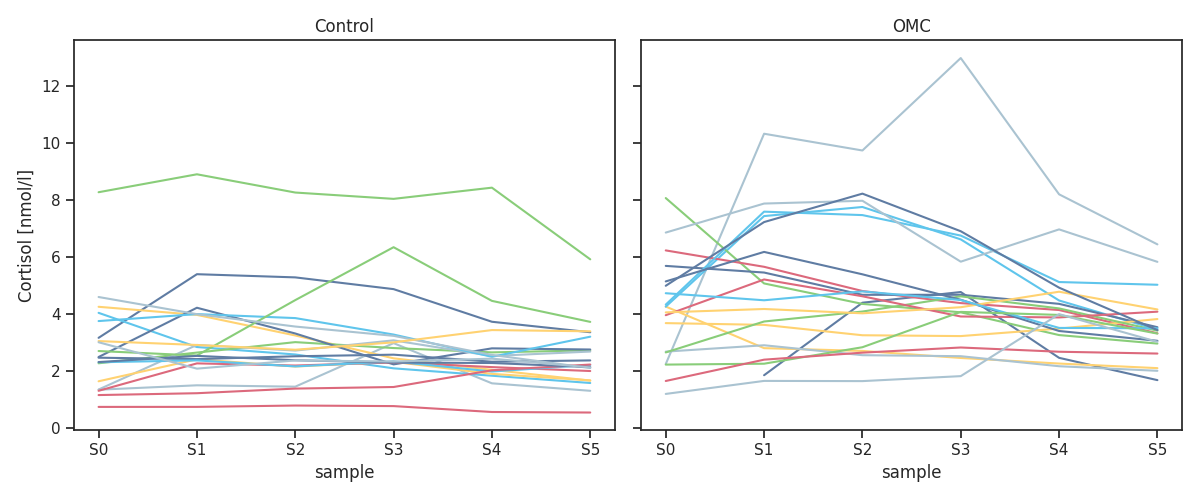

In [21]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, sharey=True)

dataset.cortisol.unstack()["cortisol"].xs("Control", level="condition").T.plot(ax=axs[0], legend=False, title="Control")
dataset.cortisol.unstack()["cortisol"].xs("OMC", level="condition").T.plot(ax=axs[1], legend=False, title="OMC")

axs[0].set_ylabel("Cortisol [nmol/l]")

# sns.lineplot(data=dataset.cortisol.reset_index(), x="sample", y="cortisol", ax=ax)

fig.tight_layout()

### Cortisol Features

#### Mean and Standard Deviation per Condition

In [22]:
cortisol_features_agg = cortisol_features.groupby(["condition", "saliva_feature"]).agg(["mean", "std"]).unstack("condition")
cortisol_features_agg = cortisol_features_agg.reorder_levels([0, 2, 1], axis=1).sort_index(axis=1)
cortisol_features_agg

cortisol                                   
condition            Control                    OMC            
                        mean        std        mean         std
saliva_feature                                                 
auc_g             168.381770  87.913237  262.185016   91.951801
auc_i               4.598557  38.318537   20.705068   95.686709
inc_S0S1            0.282519   0.851189    0.901613    2.267383
inc_S0S1_percent   17.031338  37.812539   34.863552   84.097462
max_inc             0.678098   1.118621    1.461971    2.788523
max_inc_percent    37.325274  50.925572   61.507585  116.761680

#### Statistical Analyses

In [23]:
cortisol_features_to_analyze = ["inc_S0S1", "max_inc", "max_inc_percent", "auc_i"]

In [24]:
cortisol_features_analysis = cortisol_features.reindex(cortisol_features_to_analyze, level="saliva_feature")
cortisol_features_analysis.unstack().head()

cortisol                                     
saliva_feature    inc_S0S1   max_inc max_inc_percent      auc_i
subject condition                                              
VP_01   OMC            NaN       NaN             NaN        NaN
VP_02   Control    2.22980   2.22980       70.206703   64.93960
VP_05   Control    0.15460   1.63200      120.132499   16.52540
VP_06   OMC        8.07005  10.72155      474.940752  322.61375
VP_07   Control   -0.28390  -0.28390       -6.658302  -56.50560

In [25]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "pairwise_tests")],
        params={
            "dv": "cortisol",
            "subject": "subject",
            "between": "condition",
            "parametric": False,
            "multicomp": {"method": "bonf", "levels": True},
            "groupby": "saliva_feature"
        },
    )

pipeline.apply(cortisol_features_analysis)
pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,subject,between,parametric,multicomp,groupby
parameter,cortisol,subject,condition,False,"{'method': 'bonf', 'levels': True}",saliva_feature


,prep,test
parameter,normality,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
saliva_feature  condition                          
auc_i           OMC        0.861250  0.0103   False
                Control    0.953401  0.4217    True
inc_S0S1        OMC        0.849241  0.0065   False
                Control    0.949065  0.3531    True
max_inc         OMC        0.826232  0.0028   False
                Control    0.953693  0.4266    True
max_inc_percent OMC        0.662487  0.0000   False
                Control    0.895096  0.0334   False

<font size="3"><b> Statistical Tests </b></font>

**Pairwise Tests**

,,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,p-corr
saliva_feature,,,,,,,,,,,
auc_i,0,condition,Control,OMC,False,False,173.0,two-sided,0.6429,-0.218626,1.0
inc_S0S1,0,condition,Control,OMC,False,False,156.0,two-sided,0.3466,-0.357789,1.0
max_inc,0,condition,Control,OMC,False,False,151.0,two-sided,0.2794,-0.365018,1.0
max_inc_percent,0,condition,Control,OMC,False,False,181.0,two-sided,0.8112,-0.265444,1.0


/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x78083dbe6ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]


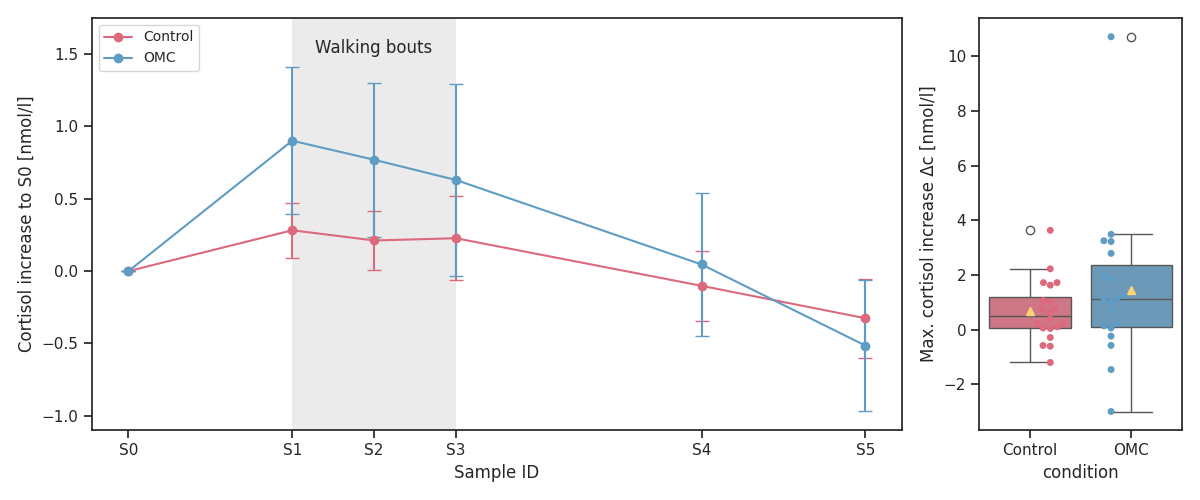

In [63]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})

bp.protocols.plotting.saliva_plot(
    data=cortisol_normalized,
    saliva_type="cortisol",
    sample_times=[0, 1, 1.5, 2, 3.5, 4.5],
    test_times=[1, 2],
    test_title="Walking bouts",
    sample_times_absolute=True,
    x_offset=0,
    ax=ax,
    palette=stressgait
)
ax.set_ylim([-1.1, 1.75])
ax.set_xticklabels([f"S{i}" for i in range(0, 6)])
ax.set_xlabel("Sample ID")
ax.set_ylabel("Cortisol increase to S0 [nmol/l]")
#ax1.axhline(y=1.5, linestyle="--", color="black", linewidth=1)

sns.boxplot(data =cortisol_features.xs("max_inc",level="saliva_feature").reset_index(), ax=ax1, palette=stressgait_palette, x="condition", y="cortisol", hue="condition", order=order,showmeans=True)
sns.swarmplot(data =cortisol_features.xs("max_inc",level="saliva_feature").reset_index(), ax=ax1, palette=stressgait_palette, x="condition", y="cortisol",  hue="condition", order=order, dodge=True,)
ax1.set_ylabel("Max. cortisol increase Δc [nmol/l]")
fig.tight_layout()
fig.savefig(plot_path.joinpath("cortisol_plot_paper.pdf"), transparent=True)

#### Plots

/tmp/ipykernel_18847/3578354713.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=4)


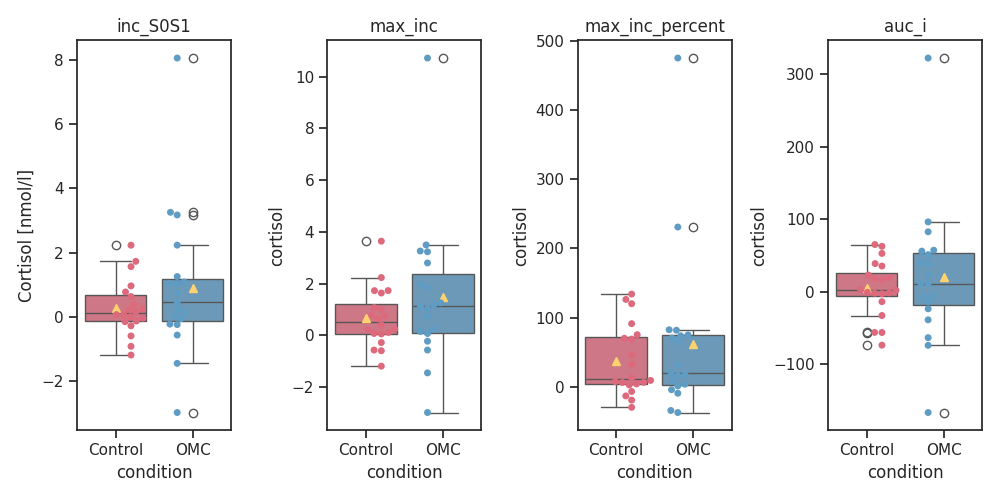

In [36]:
fig, axs = plt.subplots(ncols=4)
feature_names = ["ΔS1", "Δc", "Δc", "auc"]
for key, ax in zip(["inc_S0S1", "max_inc", "max_inc_percent", "auc_i"], axs, strict=False):
    data_slice = cortisol_features.xs(key, level="saliva_feature")
    sns.boxplot(
        data=data_slice.reset_index(), x="condition", y="cortisol", hue="condition", order=order, ax=ax, showmeans=True, palette=stressgait_palette)
    sns.swarmplot(
        data=data_slice.reset_index(), x="condition", y="cortisol", hue="condition", order=order, ax=ax, palette=stressgait_palette, dodge=True)

    ax.set_title(key)

axs[0].set_ylabel("Cortisol [nmol/l]")


fig.tight_layout()
fig.savefig(plot_path.joinpath("img_boxplot_cortisol_features.pdf"), transparent=True)

### Analysis Responder vs. Non-Responder

#### Considering S0S1 increase

In [ ]:
responder_list = cortisol_features.xs("inc_S0S1", level="saliva_feature") > 1.5

# display(responder_list)

pd.DataFrame(responder_list["cortisol"].groupby("condition").value_counts())

#### Considering Maximum increase

In [ ]:
responder_list = cortisol_features.xs("max_inc_percent", level="saliva_feature") > 1.5

# display(responder_list)

pd.DataFrame(responder_list["cortisol"].groupby("condition").value_counts())